In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
from collections import Counter

In [2]:
data =  spec1d.Spec1d('../HE0435_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#print(data)



Reading spectrum from ../HE0435_spec.fits
Expected file format: mwa
 Spectrum Start:  5570.31
 Spectrum End:     7899.01
 Dispersion (1st pixel):   0.58
 Dispersion (average):      0.58



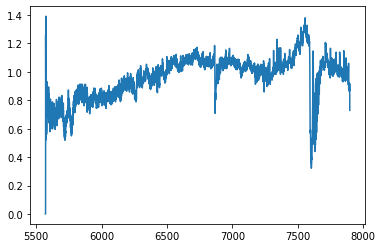

In [3]:
median_spectra_gal = np.median(data['flux'])       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
plt.plot(lamda_galaxy, spectra_galaxy_normalized)

In [4]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 31.213817586671198


In [5]:
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)

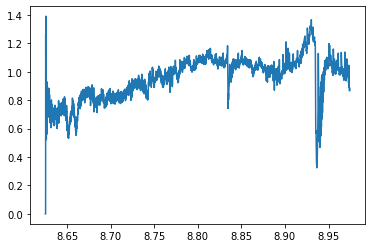

In [6]:
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)

In [7]:
template_data = spec1d.Spec1d('../TEXT/101484.txt')
lamda_template = template_data['wav']                      # wavelength in angstrom
spectra_template = template_data['flux']                     # spectra
lamda_template_range = [np.min(lamda_template), np.max(lamda_template)]
#print(lamda_template_range)


Reading spectrum from ../TEXT/101484.txt
Expected file format: text
 Spectrum Start:  3465.00
 Spectrum End:     9469.00
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



In [8]:
spectra_template_rebinned, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template,
                                                                  velscale=velocity_scale)

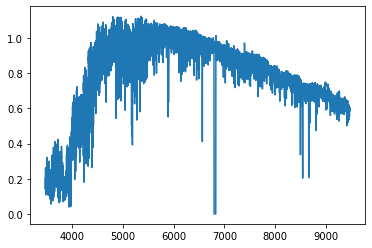

In [9]:
plt.plot(lamda_template, spectra_template)

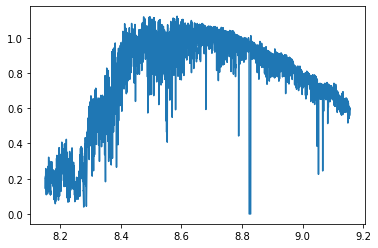

In [10]:
plt.plot(log_lamda_template, spectra_template_rebinned)

In [11]:
fwhm_template_spectra = 1.35        ## according to the paper A&A 531, A109 (2011)

def gen_sigma_diff(sig_ins):
    
    sigma_instrument = sig_ins                           #sigma of the instrumental LSF
    fwhm_galaxy = 2.355 * sigma_instrument           # FWHM of every pixel in Angstrom
    fwhm_galaxy_spectra  = np.full(len(lamda_galaxy), fwhm_galaxy)
    
    fwhm_interp_gal_spec = np.interp(lamda_template, lamda_galaxy, fwhm_galaxy_spectra)  #interpolated fwhm
    fwhm_diff = np.sqrt(fwhm_interp_gal_spec**2 - fwhm_template_spectra**2)
    sigma_diff = fwhm_diff / 2.355
    
    return sigma_diff

In [12]:
sigma_instrument = 0.95
sigma_diff = gen_sigma_diff(sigma_instrument)

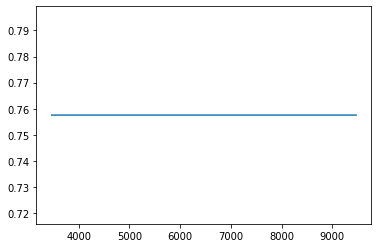

In [13]:
plt.plot(lamda_template, sigma_diff)

In [14]:
dv = c*np.log(lamda_template[0]/lamda_galaxy[0]) 

In [15]:
z = 0.454              # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  
#print(vel)

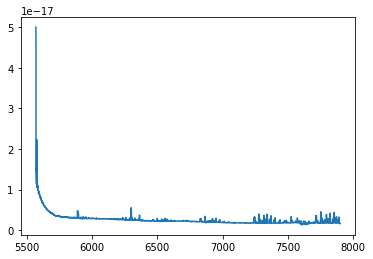

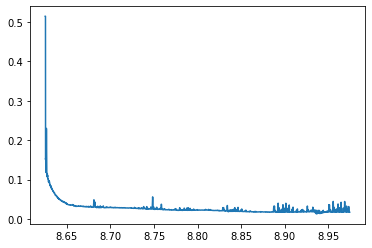

In [16]:
sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range,
                                                             noise,
                                                           velscale=velocity_scale)
plt.plot(lamda_galaxy, sigma_galaxy_spectra)
plt.figure()
#print(velo_scale)
#print(np.size(noise_new))
plt.plot(log_lamda_noise, noise_rebinned)

In [17]:
def masking(length, pixel_range, log_lamda_gal):
    '''
    This function generate and returns a boolean array with value 'False'
    in the pixel locations which should be excluded from the fit.
    
    Parameters
    ---------------
    length: int
        The length of the logarithmically rebinned galaxy spectra. The 
        boolean array would be of the same size.
        
    pixel_range: list
        A list of tuples where each tuple contains start and end of the
        pixel range needs to be excluded.
        
    log_lamda_gal: array
        This array contains the values of the logarithmically 
        rebinned wavelengths.
    
    Returns
    -------------
    mask : boolean array
        Boolean array with with value 'False' in the pixel locations 
        which should be excluded from the fit.
        
    '''
    
    mask = np.zeros(length, dtype=bool)
    for i,p in enumerate(pixel_range):
        mask |= (log_lamda_gal>=p[0]) & (log_lamda_gal <= p[1])
    return (~mask)

In [18]:
# Extended masking
pixel_range = [[(8.8305, 8.8422), (8.91412, 8.94774)], [(8.6252, 8.62938), (8.8268, 8.84623),
                (8.91133, 8.9749)], [(8.6236, 8.6352), (8.82, 8.9749)]]

In [19]:
#mask = masking(spectra_galaxy_rebinned.size, pixel_range_new, log_lamda_galaxy)

In [20]:
def gen_rebinned_templates(temp_num, temp_array, sigma_diff):
    
    filename = []
    
    if(temp_num):
        indo_us_library = glob.glob('../TEXT/*')[:temp_num]
        templates = np.empty((spectra_template_rebinned.size, len(indo_us_library)))
    

        for j, file_name in enumerate(indo_us_library):
        
            filename.append(file_name)
        
            template_data = spec1d.Spec1d(file_name, verbose=False)
            template_spectra = template_data['flux']

            # perform convolution with variable sigma_diff    
            convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

            template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
            templates[:, j] = template_spectra_rebinned / np.median(template_spectra_rebinned) # Normalizes 
                                                                                           # templates
        return templates, filename
    else:
        
        templates = np.empty((spectra_template_rebinned.size, len(temp_array)))
        
        for j, file_name in enumerate(temp_array):
        
            filename.append(file_name)
        
            template_data = spec1d.Spec1d(file_name, verbose=False)
            template_spectra = template_data['flux']

            # perform convolution with variable sigma_diff    
            convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

            template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
            templates[:, j] = template_spectra_rebinned / np.median(template_spectra_rebinned) # Normalizes 
                                                                                           # templates
        return templates, filename

### Here we are varying template numbers and recording which template files have been used to fit. ppxf provides an array of wieghts assigned to each of the templates during the fit procedure. Finding out the indexes of the nonzero elements from the weight array and matching them with the array containing all the template file names we can find out which templates have been used.

In [32]:
template_number = [150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1266]
#tamplates,  = gen_rebinned_templates(200, sigma_diff)
degree = np.arange(4, 21)

template number: 1050 

1050

 degree : 4

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 5

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 6

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 7

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 8

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 9

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 10

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 11

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 12

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 13

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 14

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 15

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 16

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 17

 mask_option : 0

 mask_option : 1

 mask_option : 2

 degree : 18

 mask_opti

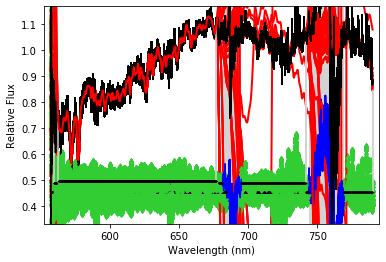

In [33]:
#total_used_template_list = []     # A list of lists containing template file names being used 

f = open('used_templates_new.txt', 'a+')
g = open('vel_dis_vary_temp_deg_mask.txt', 'a+')

for i, p in enumerate(template_number):
    
    templates, file_name = gen_rebinned_templates(p, 0, sigma_diff)
    
    print('template number: %d \n' %p)
    print(len(file_name))
    
    for d in range(len(degree)):
        print('\n degree : %d' %degree[d])
        
        for m, pix in enumerate(pixel_range):
            print('\n mask_option : %d' %m)
            
            mask = masking(spectra_galaxy_rebinned.size, pix, log_lamda_galaxy)
            
            pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
                 plot=True, vsyst=dv, degree=degree[d], mask=mask, lam=np.exp(log_lamda_galaxy), quiet=True)
            
            g.write("velocity dispersion: %f km/s; chi^2: %f;\n" %(pp.sol[1], pp.chi2))
    
    
            non_zero_temp_index = []
            high_weight_temp_index = []
            for j, weight in enumerate(pp.weights):
    
                if (weight > 0.0 and weight < 2.0):
                    non_zero_temp_index.append(j)
                
                elif (weight >= 2.0) :
                    high_weight_temp_index.append(j)
    
            for k, index in enumerate(non_zero_temp_index):
    
                #print(file_name[index])
                f.write(file_name[index])
                f.write('\n')
                #used_template.append(file_name[index])
            for h, index in enumerate(high_weight_temp_index):
                    
                print(file_name[index])
    
                #total_used_template_list.append(used_template)
f.close()
g.close()

In [28]:
used_file_data = []
with open('used_templates_new.txt', 'r') as file:
        
        for line in file:
            used_file_data.append(line.strip())

### Here we have  a count of how many times each template from the list of total used templates have been used while we varied provived template numbers, degree and masking region.

In [29]:
cnt = Counter()
for i, p in enumerate(used_file_data):
        
        cnt[p] += 1

In [30]:
total_template_set = []
for i,p in enumerate(cnt):
    total_template_set.append(p)

In [31]:
len(cnt)

243

In [32]:
odd_template = ['../TEXT/147700.txt', '../TEXT/213660.txt', '../TEXT/BD-10_3166.txt', '../TEXT/223869.txt',
                 '../TEXT/8890.txt', '../TEXT/13475.txt', '../TEXT/39118.txt', '../TEXT/156164.txt',
                '../TEXT/187796.txt']

for i, p in enumerate(odd_template):
    
    print(p)
    if (p in total_template_set):
        
        total_template_set.remove(p)
        print(i)

../TEXT/147700.txt
../TEXT/213660.txt
../TEXT/BD-10_3166.txt
2
../TEXT/223869.txt
../TEXT/8890.txt
../TEXT/13475.txt
../TEXT/39118.txt
../TEXT/156164.txt
../TEXT/187796.txt


In [33]:
len(total_template_set)

242

In [34]:
f = open('used_temp_spectra_type_1.txt', 'w+')

f.write(" filename  \tSPTYPE\tusage\n")
for i, p in enumerate(total_template_set):
    temp_spec = open(p, 'r')
    flag = 1
    
    for line in temp_spec:
    
        if 'SPTYPE' in line:
            l = line.strip()
            f.write("%s\t%s\t%d\n" %(p[8:], l[12:], int(cnt[p])))
            #print(total_template_set.index(p))
            #print(l)
            flag = 0
    if(flag):
        print(total_template_set.index(p))
        print(p)
        f.write('%s\t%s\t%d\n' %(p[8:], 'flat', int(cnt[p])))
f.close()

176
../TEXT/BD+09_3223.txt
223
../TEXT/BD+09_3063.txt


In [21]:
t = pd.read_csv('used_temp_spectra_type_1.txt', delimiter='\t')

In [29]:
spec_dictionary = {"O": 0, "B": 0, "A":0, "F": 0, "G": 0, "K": 0, "M":0, "C": 0, "Other": 0}

In [30]:
for i, p in enumerate(t[1]):
    
    string = t[2][i]
    if p[10] in ["O", "B", "A", "F", "G", "K", "M", "C"] :
        #print(p[10])
        #print(t[2][i])
        spec_dictionary[p[10]] += int(string.split()[2])
        #print(string)
        #print(int(string.split()[2]))
    else:
        spec_dictionary["Other"] += int(string.split()[2])
        print(t[0][i])
        print(string)
        print(int(string.split()[2]))
        

filename : 1967.txt
 used : 460 times
460
filename : 161817.txt
 used : 75 times
75
filename : 49368.txt
 used : 104 times
104
filename : BD+09_3223.txt
 used : 49 times
49
filename : 140283.txt
 used : 124 times
124
filename : G_245-32.txt
 used : 6 times
6
filename : BD+09_3063.txt
 used : 71 times
71


In [31]:
spec_dictionary["Other"] -= 75
spec_dictionary["A"] += 75
spec_dictionary["Other"] -= 124
spec_dictionary["F"] += 124
spec_dictionary["Other"] -= 6
spec_dictionary["F"] += 6

In [32]:
print(spec_dictionary)
sum(spec_dictionary.values())

{'O': 111, 'B': 388, 'A': 544, 'F': 1398, 'G': 2266, 'K': 2918, 'M': 926, 'C': 612, 'Other': 684}


9847

Text(0.5, 0, 'spectral type')

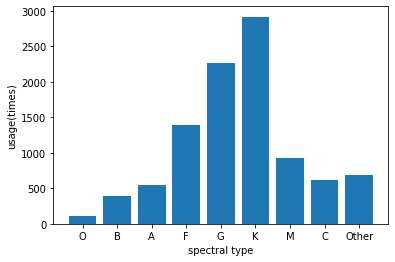

In [33]:
plt.bar(spec_dictionary.keys(), spec_dictionary.values())
plt.ylabel('usage(times)')
plt.xlabel('spectral type')

### Checking the spectral type distribution of the template dictionary

In [35]:
spec_temp = {"O": 0, "B": 0, "A": 0, "F": 0, "G": 0, "K": 0, "M":0, "C": 0, "Other": 0}

for i, p in enumerate(total_template_set):
    temp_spec = open(p, 'r')
    flag = 1
    print(p)
    for line in temp_spec:
    
        if 'SPTYPE' in line:
            flag = 0
            l = line.strip()
            print(l[12:17])
            f = 1
            for char in l[12:16]:
                if char in ["O", "B", "A", "F", "G", "K", "M", "C"] :
                
                    spec_temp[char] += 1
                    print(spec_temp)
                    f = 0
                    break
            #f.write("%s\t%s\t%d\n" %(p[8:], l[12:], int(cnt[p])))
            #print(total_template_set.index(p))
            #print(l)
            
            if  f:
                spec_temp["Other"] += 1
                        
    if(flag):
        spec_temp["Other"] += 1

../TEXT/215373.txt
K0III
{'O': 0, 'B': 0, 'A': 0, 'F': 0, 'G': 0, 'K': 1, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/207089.txt
K0Iab
{'O': 0, 'B': 0, 'A': 0, 'F': 0, 'G': 0, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/151613.txt
F2V
{'O': 0, 'B': 0, 'A': 0, 'F': 1, 'G': 0, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/51309.txt
B3Ib/
{'O': 0, 'B': 1, 'A': 0, 'F': 1, 'G': 0, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/206267.txt
O6e
{'O': 1, 'B': 1, 'A': 0, 'F': 1, 'G': 0, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/193322.txt
O9V
{'O': 2, 'B': 1, 'A': 0, 'F': 1, 'G': 0, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/134474.txt
G5
{'O': 2, 'B': 1, 'A': 0, 'F': 1, 'G': 1, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/202904.txt
B2Vne
{'O': 2, 'B': 2, 'A': 0, 'F': 1, 'G': 1, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/39801.txt
M1
{'O': 2, 'B': 2, 'A': 0, 'F': 1, 'G': 1, 'K': 2, 'M': 1, 'C': 0, 'Other': 0}
../TEXT/1967.txt
Se...
../TEXT/223047.txt
G5Ib+
{'O': 2, 'B': 2, 'A': 0, 'F': 1, 'G': 2, 'K': 2,

../TEXT/181276.txt
G9III
{'O': 3, 'B': 8, 'A': 8, 'F': 31, 'G': 37, 'K': 43, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/182572.txt
G8IV.
{'O': 3, 'B': 8, 'A': 8, 'F': 31, 'G': 38, 'K': 43, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/232078.txt
K3IIp
{'O': 3, 'B': 8, 'A': 8, 'F': 31, 'G': 38, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/29574.txt
G8/K0
{'O': 3, 'B': 8, 'A': 8, 'F': 31, 'G': 39, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/137510.txt
G0IV-
{'O': 3, 'B': 8, 'A': 8, 'F': 31, 'G': 40, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/102574.txt
F7V
{'O': 3, 'B': 8, 'A': 8, 'F': 32, 'G': 40, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/107950.txt
G6III
{'O': 3, 'B': 8, 'A': 8, 'F': 32, 'G': 41, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/76780.txt
G5
{'O': 3, 'B': 8, 'A': 8, 'F': 32, 'G': 42, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/G_230-49.txt
G0
{'O': 3, 'B': 8, 'A': 8, 'F': 32, 'G': 43, 'K': 44, 'M': 7, 'C': 4, 'Other': 2}
../TEXT/199960.txt
G1V
{'O': 3, 'B': 8, 'A': 8, 'F': 32, 'G': 4

M0III
{'O': 4, 'B': 12, 'A': 12, 'F': 47, 'G': 66, 'K': 62, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/130952.txt
G8III
{'O': 4, 'B': 12, 'A': 12, 'F': 47, 'G': 67, 'K': 62, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/199478.txt
B8Iae
{'O': 4, 'B': 13, 'A': 12, 'F': 47, 'G': 67, 'K': 62, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/126141.txt
F5V
{'O': 4, 'B': 13, 'A': 12, 'F': 48, 'G': 67, 'K': 62, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/132345.txt
K3III
{'O': 4, 'B': 13, 'A': 12, 'F': 48, 'G': 67, 'K': 63, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/223385.txt
A3Iae
{'O': 4, 'B': 13, 'A': 13, 'F': 48, 'G': 67, 'K': 63, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/63302.txt
K3Iab
{'O': 4, 'B': 13, 'A': 13, 'F': 48, 'G': 67, 'K': 64, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/180028.txt
F6Ib
{'O': 4, 'B': 13, 'A': 13, 'F': 49, 'G': 67, 'K': 64, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/110010.txt
G0
{'O': 4, 'B': 13, 'A': 13, 'F': 49, 'G': 68, 'K': 64, 'M': 18, 'C': 5, 'Other': 4}
../TEXT/G_196-9.txt
K5
{'O': 4, 'B': 13, 'A': 13, 'F':

<BarContainer object of 9 artists>

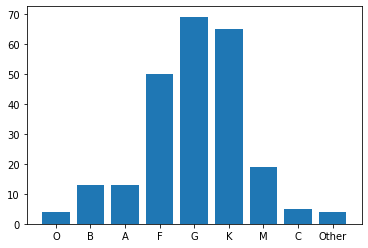

In [36]:
plt.bar(spec_temp.keys(), spec_temp.values())

Text(0.5, 0, 'spectral type')

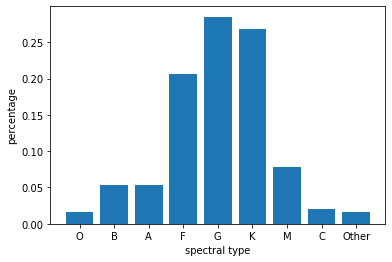

In [50]:
spec_temp_value = list(spec_temp.values())
x = np.array(spec_temp_value)
plt.bar(spec_temp.keys(), x / 242)
plt.ylabel('percentage')
plt.xlabel('spectral type')

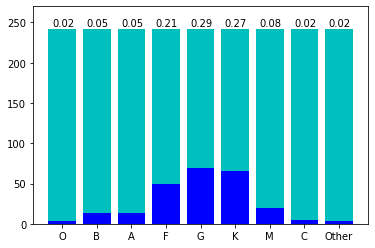

In [76]:
plt.bar(spec_temp.keys(), 242, color='c')
plt.bar(spec_temp.keys(), x, color='b')
plt.ylim(0, 270)
text = x/242
for i,p in enumerate(x):
    plt.annotate(round(text[i], 2), xy=(i-.3, 245))
    #print(round(text[i], 2))

In [66]:
sum(spec_temp.values())

242

### Checking spectral diversification in Indo-US library

In [45]:
indo_us_library = glob.glob('../TEXT/*')

In [66]:
spec_indo_us = {"O": 0, "B": 0, "A": 0, "F": 0, "G": 0, "K": 0, "M":0, "C": 0, "Other": 0}

for i, p in enumerate(indo_us_library):
    temp_spec = open(p, 'r')
    flag = 1
    print(p)
    for line in temp_spec:
    
        if 'SPTYPE' in line:
            flag = 0
            l = line.strip()
            print(l[12:17])
            f = 1
            for char in l[12:16]:
                if char in ["O", "B", "A", "F", "G", "K", "M", "C"] :
                
                    spec_indo_us[char] += 1
                    print(spec_indo_us)
                    f = 0
                    break
            #f.write("%s\t%s\t%d\n" %(p[8:], l[12:], int(cnt[p])))
            #print(total_template_set.index(p))
            #print(l)
            
            if  f:
                spec_indo_us["Other"] += 1
                        
    if(flag):
        spec_indo_us["Other"] += 1
            

../TEXT/84453.txt
K0IV
{'O': 0, 'B': 0, 'A': 0, 'F': 0, 'G': 0, 'K': 1, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/8512.txt
K0III
{'O': 0, 'B': 0, 'A': 0, 'F': 0, 'G': 0, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/175535.txt
G7III
{'O': 0, 'B': 0, 'A': 0, 'F': 0, 'G': 1, 'K': 2, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/215373.txt
K0III
{'O': 0, 'B': 0, 'A': 0, 'F': 0, 'G': 1, 'K': 3, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/193536.txt
B2V
{'O': 0, 'B': 1, 'A': 0, 'F': 0, 'G': 1, 'K': 3, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/195135.txt
K2III
{'O': 0, 'B': 1, 'A': 0, 'F': 0, 'G': 1, 'K': 4, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/110897.txt
G0V
{'O': 0, 'B': 1, 'A': 0, 'F': 0, 'G': 2, 'K': 4, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/37394.txt
K1V
{'O': 0, 'B': 1, 'A': 0, 'F': 0, 'G': 2, 'K': 5, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/20902.txt
F5Iab
{'O': 0, 'B': 1, 'A': 0, 'F': 1, 'G': 2, 'K': 5, 'M': 0, 'C': 0, 'Other': 0}
../TEXT/209409.txt
B7IVe
{'O': 0, 'B': 2, 'A': 0, 'F': 1, 'G': 2, 'K': 5, 'M': 0, 'C': 0, 'Oth

../TEXT/112030.txt
G7III
{'O': 2, 'B': 18, 'A': 11, 'F': 24, 'G': 52, 'K': 35, 'M': 4, 'C': 0, 'Other': 1}
../TEXT/197939.txt
M3III
{'O': 2, 'B': 18, 'A': 11, 'F': 24, 'G': 52, 'K': 35, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/37986.txt
G8/K0
{'O': 2, 'B': 18, 'A': 11, 'F': 24, 'G': 53, 'K': 35, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/95849.txt
K3III
{'O': 2, 'B': 18, 'A': 11, 'F': 24, 'G': 53, 'K': 36, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/81797.txt
K3II-
{'O': 2, 'B': 18, 'A': 11, 'F': 24, 'G': 53, 'K': 37, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/87737.txt
A0Ib
{'O': 2, 'B': 18, 'A': 12, 'F': 24, 'G': 53, 'K': 37, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/98744.txt
G0
{'O': 2, 'B': 18, 'A': 12, 'F': 24, 'G': 54, 'K': 37, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/105262.txt
B9
{'O': 2, 'B': 19, 'A': 12, 'F': 24, 'G': 54, 'K': 37, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/G_196-48.txt
G
{'O': 2, 'B': 19, 'A': 12, 'F': 24, 'G': 55, 'K': 37, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/215721.txt
G8III
{'O': 2, 'B': 19, 'A': 12,

../TEXT/249.txt
K1IV
{'O': 2, 'B': 22, 'A': 23, 'F': 42, 'G': 83, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/BD+37_2312.txt
G7III
{'O': 2, 'B': 22, 'A': 23, 'F': 42, 'G': 84, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/157373.txt
F4V
{'O': 2, 'B': 22, 'A': 23, 'F': 43, 'G': 84, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/43247.txt
B9II-
{'O': 2, 'B': 23, 'A': 23, 'F': 43, 'G': 84, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/126868.txt
G2IV
{'O': 2, 'B': 23, 'A': 23, 'F': 43, 'G': 85, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/196740.txt
B5IV
{'O': 2, 'B': 24, 'A': 23, 'F': 43, 'G': 85, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/54322.txt
G5
{'O': 2, 'B': 24, 'A': 23, 'F': 43, 'G': 86, 'K': 58, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/163588.txt
K2III
{'O': 2, 'B': 24, 'A': 23, 'F': 43, 'G': 86, 'K': 59, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/105546.txt
G2III
{'O': 2, 'B': 24, 'A': 23, 'F': 43, 'G': 87, 'K': 59, 'M': 5, 'C': 0, 'Other': 1}
../TEXT/223075.txt
CII..
{'O': 2, 'B': 24, 'A'

../TEXT/G_180-35.txt
K0V
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 107, 'K': 77, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/44007.txt
G5IV:
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 108, 'K': 77, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/216640.txt
K1III
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 108, 'K': 78, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/114203.txt
K0
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 108, 'K': 79, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/63791.txt
G0
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 109, 'K': 79, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/57651.txt
K5
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 109, 'K': 80, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/94264.txt
K0III
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 109, 'K': 81, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/221861.txt
G9Ib
{'O': 3, 'B': 39, 'A': 30, 'F': 56, 'G': 110, 'K': 81, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/56986.txt
F0IV
{'O': 3, 'B': 39, 'A': 30, 'F': 57, 'G': 110, 'K': 81, 'M': 11, 'C': 1, 'Other': 1}
../TEXT/41636.txt
G9III
{'O': 3, 'B

A0V
{'O': 3, 'B': 44, 'A': 43, 'F': 75, 'G': 132, 'K': 100, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/25457.txt
F5V
{'O': 3, 'B': 44, 'A': 43, 'F': 76, 'G': 132, 'K': 100, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/180006.txt
G8III
{'O': 3, 'B': 44, 'A': 43, 'F': 76, 'G': 133, 'K': 100, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/61295.txt
F6II
{'O': 3, 'B': 44, 'A': 43, 'F': 77, 'G': 133, 'K': 100, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/10761.txt
G8III
{'O': 3, 'B': 44, 'A': 43, 'F': 77, 'G': 134, 'K': 100, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/204771.txt
K0III
{'O': 3, 'B': 44, 'A': 43, 'F': 77, 'G': 134, 'K': 101, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/205139.txt
B1II
{'O': 3, 'B': 45, 'A': 43, 'F': 77, 'G': 134, 'K': 101, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/58526.txt
G3Ib
{'O': 3, 'B': 45, 'A': 43, 'F': 77, 'G': 135, 'K': 101, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/153597.txt
F6Vva
{'O': 3, 'B': 45, 'A': 43, 'F': 78, 'G': 135, 'K': 101, 'M': 12, 'C': 3, 'Other': 1}
../TEXT/135742.txt
B8V
{'O': 3, 'B': 46,

G0
{'O': 4, 'B': 53, 'A': 48, 'F': 90, 'G': 154, 'K': 127, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/152792.txt
G0V
{'O': 4, 'B': 53, 'A': 48, 'F': 90, 'G': 155, 'K': 127, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/25173.txt
F8V
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 155, 'K': 127, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/G_139-48.txt
G0V
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 156, 'K': 127, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/154278.txt
K1III
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 156, 'K': 128, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/48432.txt
K0III
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 156, 'K': 129, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/G_108-43.txt
G0
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 157, 'K': 129, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/166229.txt
K2.5I
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 157, 'K': 130, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/116292.txt
K0III
{'O': 4, 'B': 53, 'A': 48, 'F': 91, 'G': 157, 'K': 131, 'M': 14, 'C': 4, 'Other': 1}
../TEXT/BD+27_2057.txt
G7III
{'O': 4, '

../TEXT/222368.txt
F7V
{'O': 6, 'B': 65, 'A': 51, 'F': 111, 'G': 172, 'K': 151, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/G_170-47.txt
G0
{'O': 6, 'B': 65, 'A': 51, 'F': 111, 'G': 173, 'K': 151, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/233891.txt
G5III
{'O': 6, 'B': 65, 'A': 51, 'F': 111, 'G': 174, 'K': 151, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/G_12-22.txt
G8V
{'O': 6, 'B': 65, 'A': 51, 'F': 111, 'G': 175, 'K': 151, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/54719.txt
K2III
{'O': 6, 'B': 65, 'A': 51, 'F': 111, 'G': 175, 'K': 152, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/150680.txt
G0IV
{'O': 6, 'B': 65, 'A': 51, 'F': 111, 'G': 176, 'K': 152, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/151862.txt
A1V
{'O': 6, 'B': 65, 'A': 52, 'F': 111, 'G': 176, 'K': 152, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/148513.txt
K4III
{'O': 6, 'B': 65, 'A': 52, 'F': 111, 'G': 176, 'K': 153, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/30614.txt
O9.5I
{'O': 7, 'B': 65, 'A': 52, 'F': 111, 'G': 176, 'K': 153, 'M': 14, 'C': 5, 'Other': 2}
../TEXT/20

../TEXT/99747.txt
F5Vaw
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 194, 'K': 179, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/107418.txt
K0III
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 194, 'K': 180, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/19787.txt
K2III
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 194, 'K': 181, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/113226.txt
G8III
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 195, 'K': 181, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/105755.txt
G0Vw
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 196, 'K': 181, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/130025.txt
K0
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 196, 'K': 182, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/210939.txt
K1III
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 196, 'K': 183, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/43232.txt
K1.5I
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 196, 'K': 184, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/37088.txt
G0
{'O': 7, 'B': 74, 'A': 61, 'F': 127, 'G': 197, 'K': 184, 'M': 15, 'C': 6, 'Other': 2}
../TEXT/1887

G1/G2
{'O': 7, 'B': 81, 'A': 71, 'F': 139, 'G': 222, 'K': 202, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/77601.txt
F6II-
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 222, 'K': 202, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/107328.txt
K0III
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 222, 'K': 203, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/89490.txt
K0
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 222, 'K': 204, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/138905.txt
K0III
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 222, 'K': 205, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/45282.txt
G0
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 223, 'K': 205, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/140027.txt
G8III
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 224, 'K': 205, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/G_60-6.txt
K2
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 224, 'K': 206, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/218857.txt
G6w
{'O': 7, 'B': 81, 'A': 71, 'F': 140, 'G': 225, 'K': 206, 'M': 19, 'C': 6, 'Other': 4}
../TEXT/117176.txt
G5V
{'O': 7, 'B

../TEXT/41117.txt
B2Iae
{'O': 8, 'B': 87, 'A': 78, 'F': 143, 'G': 255, 'K': 232, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/179761.txt
B8II-
{'O': 8, 'B': 88, 'A': 78, 'F': 143, 'G': 255, 'K': 232, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/109995.txt
A0p
{'O': 8, 'B': 88, 'A': 79, 'F': 143, 'G': 255, 'K': 232, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/101673.txt
K3III
{'O': 8, 'B': 88, 'A': 79, 'F': 143, 'G': 255, 'K': 233, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/G_84-29.txt
sd:F0
{'O': 8, 'B': 88, 'A': 79, 'F': 144, 'G': 255, 'K': 233, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/48682.txt
G0V
{'O': 8, 'B': 88, 'A': 79, 'F': 144, 'G': 256, 'K': 233, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/101676.txt
F6V
{'O': 8, 'B': 88, 'A': 79, 'F': 145, 'G': 256, 'K': 233, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/11749.txt
K0III
{'O': 8, 'B': 88, 'A': 79, 'F': 145, 'G': 256, 'K': 234, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/55280.txt
K2III
{'O': 8, 'B': 88, 'A': 79, 'F': 145, 'G': 256, 'K': 235, 'M': 23, 'C': 6, 'Other': 4}
../TEXT/42

F6IV
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 275, 'K': 255, 'M': 27, 'C': 6, 'Other': 4}
../TEXT/94247.txt
K3III
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 275, 'K': 256, 'M': 27, 'C': 6, 'Other': 4}
../TEXT/185644.txt
K1III
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 275, 'K': 257, 'M': 27, 'C': 6, 'Other': 4}
../TEXT/192944.txt
G8III
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 276, 'K': 257, 'M': 27, 'C': 6, 'Other': 4}
../TEXT/36389.txt
M2Iab
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 276, 'K': 257, 'M': 28, 'C': 6, 'Other': 4}
../TEXT/78712.txt
M6III
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 276, 'K': 257, 'M': 29, 'C': 6, 'Other': 4}
../TEXT/124897.txt
K1.5I
{'O': 9, 'B': 100, 'A': 88, 'F': 160, 'G': 276, 'K': 258, 'M': 29, 'C': 6, 'Other': 4}
../TEXT/106516.txt
F5V
{'O': 9, 'B': 100, 'A': 88, 'F': 161, 'G': 276, 'K': 258, 'M': 29, 'C': 6, 'Other': 4}
../TEXT/34411.txt
G1.5I
{'O': 9, 'B': 100, 'A': 88, 'F': 161, 'G': 277, 'K': 258, 'M': 29, 'C': 6, 'Other': 4}
../TEXT/G_90-1.txt

../TEXT/85503.txt
K2III
{'O': 12, 'B': 112, 'A': 94, 'F': 177, 'G': 295, 'K': 283, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/76151.txt
G2V
{'O': 12, 'B': 112, 'A': 94, 'F': 177, 'G': 296, 'K': 283, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/157466.txt
F8V
{'O': 12, 'B': 112, 'A': 94, 'F': 178, 'G': 296, 'K': 283, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/116656.txt
A2V
{'O': 12, 'B': 112, 'A': 95, 'F': 178, 'G': 296, 'K': 283, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/83506.txt
K0III
{'O': 12, 'B': 112, 'A': 95, 'F': 178, 'G': 296, 'K': 284, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/93813.txt
K0/K1
{'O': 12, 'B': 112, 'A': 95, 'F': 178, 'G': 296, 'K': 285, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/41330.txt
G0V
{'O': 12, 'B': 112, 'A': 95, 'F': 178, 'G': 297, 'K': 285, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/120933.txt
K5III
{'O': 12, 'B': 112, 'A': 95, 'F': 178, 'G': 297, 'K': 286, 'M': 29, 'C': 6, 'Other': 5}
../TEXT/27971.txt
K1III
{'O': 12, 'B': 112, 'A': 95, 'F': 178, 'G': 297, 'K': 287, 'M': 29, 'C': 6, 'Other': 

../TEXT/4744.txt
G8IV
{'O': 12, 'B': 118, 'A': 103, 'F': 191, 'G': 323, 'K': 305, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/16458.txt
G8p..
{'O': 12, 'B': 118, 'A': 103, 'F': 191, 'G': 324, 'K': 305, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/BD+31_2356.txt
G6III
{'O': 12, 'B': 118, 'A': 103, 'F': 191, 'G': 325, 'K': 305, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/195324.txt
A1Ib
{'O': 12, 'B': 118, 'A': 104, 'F': 191, 'G': 325, 'K': 305, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/144585.txt
G5V
{'O': 12, 'B': 118, 'A': 104, 'F': 191, 'G': 326, 'K': 305, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/115444.txt
K0
{'O': 12, 'B': 118, 'A': 104, 'F': 191, 'G': 326, 'K': 306, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/149661.txt
K2V
{'O': 12, 'B': 118, 'A': 104, 'F': 191, 'G': 326, 'K': 307, 'M': 37, 'C': 6, 'Other': 7}
../TEXT/146051.txt
M0.5I
{'O': 12, 'B': 118, 'A': 104, 'F': 191, 'G': 326, 'K': 307, 'M': 38, 'C': 6, 'Other': 7}
../TEXT/138279.txt
F5
{'O': 12, 'B': 118, 'A': 104, 'F': 192, 'G': 326, 'K': 307, 'M': 38, 'C': 

K1IV
{'O': 12, 'B': 128, 'A': 108, 'F': 203, 'G': 354, 'K': 329, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/43827.txt
K1III
{'O': 12, 'B': 128, 'A': 108, 'F': 203, 'G': 354, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/7476.txt
F5V
{'O': 12, 'B': 128, 'A': 108, 'F': 204, 'G': 354, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/16895.txt
F7V
{'O': 12, 'B': 128, 'A': 108, 'F': 205, 'G': 354, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/191615.txt
G8IV
{'O': 12, 'B': 128, 'A': 108, 'F': 205, 'G': 355, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/224930.txt
G5Vb
{'O': 12, 'B': 128, 'A': 108, 'F': 205, 'G': 356, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/37216.txt
G5
{'O': 12, 'B': 128, 'A': 108, 'F': 205, 'G': 357, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/186307.txt
A6V
{'O': 12, 'B': 128, 'A': 109, 'F': 205, 'G': 357, 'K': 330, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/158899.txt
K4III
{'O': 12, 'B': 128, 'A': 109, 'F': 205, 'G': 357, 'K': 331, 'M': 42, 'C': 6, 'Other': 7}
../TEXT/28

<BarContainer object of 9 artists>

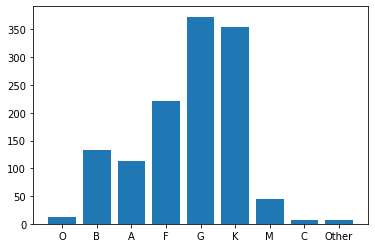

In [67]:
 plt.bar(spec_indo_us.keys(), spec_indo_us.values())

In [68]:
print(spec_indo_us)
sum(spec_indo_us.values())

{'O': 12, 'B': 133, 'A': 114, 'F': 221, 'G': 373, 'K': 354, 'M': 44, 'C': 6, 'Other': 7}


1264

In [77]:
# sorting 242 templates according to their usage
table_temp = t.sort_values(by=['usage'], ascending=False)[:60]

In [131]:
table_temp[0:20]

,filename,SPTYPE,usage
9,1967.txt,Se...,460
170,65714.txt,G8III:,404
114,142980.txt,K1IV,277
53,187929.txt,F6Iab:,262
11,107752.txt,G5,239
196,G_176-11.txt,M0.5,233
171,5394.txt,B0IVe,230
1,207089.txt,K0Iab:,227
28,19510.txt,A0,208
134,32736.txt,CII...,200


### Collecting template file names to create a set of 20 with only spectral type F, K and G with maximum usage

In [141]:
file_table = []
flag = 0
for i, p in enumerate(table_temp[' filename  '][0:50]):
    
    sptype = table_temp['SPTYPE'][table_temp.index[i]]
    
    if flag <= 19:
        for char in sptype:
            if char in ['F', 'G', 'K']:
                #print(p)
                file_table.append('../TEXT/' + p)
                #print(char)
                flag += 1
    else:
        break
#print(flag)
#print(file_table)
    #print(p)
    #print(table_temp.index[i])
    #print(table_temp['SPTYPE'][table_temp.index[i]])
     

### Doing fit to get the fiducial value of velocity dispersion with a set of 20 templates among which 10 willbe randomly selected everytime.

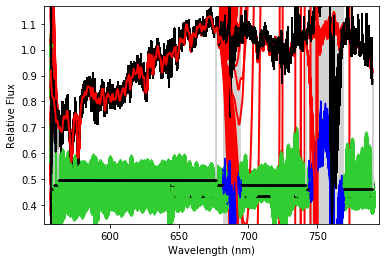

In [148]:
velocity_dispersion = []
chi_2 = []
f = open('fiducial_vel_dis.txt', 'w+')
f.write("velocity dispersion(km/s)   chi^2\n")
fl = []

for i in range(200):
    
    #spec_gal_w_noise = add_noise_to_spectra()
    #spec_gal_w_noise_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, 
    #                                                           spec_gal_w_noise, 
    #                                                          velscale=velocity_scale)
    #mask = masking(spec_gal_w_noise_rebinned.size, pixel_range_new, log_lamda_galaxy)
    templates, file_name = gen_rebinned_templates(0, sample(file_table, 10), sigma_diff)
    
    fl.append(file_name)
    
    for m, pix in enumerate(pixel_range):
        
        mask = masking(spectra_galaxy_rebinned.size, pix, log_lamda_galaxy)
        pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
             plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy), quiet=True)
    
        velocity_dispersion.append(pp.sol[1])
        chi_2.append(pp.chi2)
        f.write("     %f           %f\n" %(pp.sol[1], pp.chi2))

f.close()

std = 5.740796
mean = 224.637941


Text(0.5, 0, 'velocity dispersion')

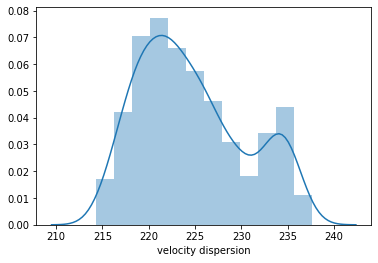

In [174]:
p = pd.read_csv('fiducial_vel_dis.txt',delim_whitespace=True)
vel = p['velocity_dispersion(km/s)']
print('std = %f' %np.std(vel))
print('mean = %f' %np.mean(vel))
sn.distplot(vel)
plt.xlabel('velocity dispersion')
#p['velocity_dispersion(km/s)']

In [175]:
p1 = p.sort_values(by=['chi^2'])
p1

,velocity_dispersion(km/s),chi^2
158,233.558288,0.699545
218,233.373221,0.699610
275,233.339379,0.699611
326,233.965277,0.699618
137,235.699159,0.699622
...,...,...
225,220.847445,1.230794
141,219.085018,1.235536
588,217.661126,1.243257
393,219.160386,1.243342


In [184]:
m_1 = []
m_2 = []
m_3 = []

for i, v in enumerate(p['velocity_dispersion(km/s)']):
    if (i%3)==0:
        m_1.append(v)
    elif (i%3)==1:
        m_2.append(v)
    elif (i%3)==2:
        m_3.append(v)

std = 3.482916
mean = 222.380176


Text(0.5, 0, 'velocity dispersion')

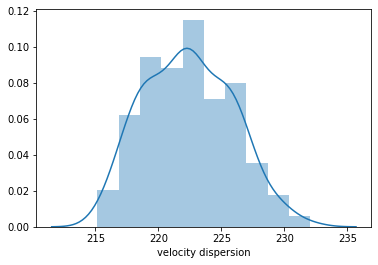

In [194]:
print('std = %f' %np.std(m_1))
print('mean = %f' %np.mean(m_1))
sn.distplot(m_1)
plt.xlabel('velocity dispersion')

std = 2.903053
mean = 220.467489


Text(0.5, 0, 'velocity dispersion')

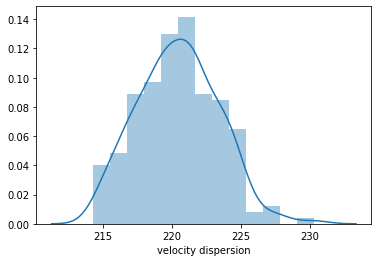

In [193]:
print('std = %f' %np.std(m_2))
print('mean = %f' %np.mean(m_2))
sn.distplot(m_2)
plt.xlabel('velocity dispersion')

std = 3.807838
mean = 231.066159


Text(0.5, 0, 'velocity dispersion')

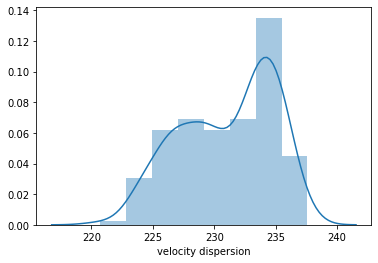

In [192]:
print('std = %f' %np.std(m_3))
print('mean = %f' %np.mean(m_3))
sn.distplot(m_3)
plt.xlabel('velocity dispersion')

In [178]:
p[:10]

,velocity_dispersion(km/s),chi^2
0,225.679368,1.130761
1,224.246060,0.931136
2,235.019555,0.700129
3,217.891363,1.226259
4,223.127774,0.931938
5,234.215170,0.702522
6,216.933300,1.218301
7,219.388714,0.948790
8,225.215459,0.718579
9,220.430218,1.120899


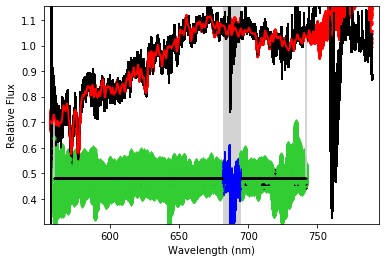

In [29]:
velocity_dispersion = []
chi_2 = []
f = open('vel_dis_MC_new.txt', 'w+')

fl = []

for i in range(800):
    
    #spec_gal_w_noise = add_noise_to_spectra()
    #spec_gal_w_noise_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, 
    #                                                           spec_gal_w_noise, 
    #                                                          velscale=velocity_scale)
    #mask = masking(spec_gal_w_noise_rebinned.size, pixel_range_new, log_lamda_galaxy)
    templates, file_name = gen_rebinned_templates(0, sample(total_template_set, 20), sigma_diff)
    
    fl.append(file_name)
    
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy), quiet=True)
    
    velocity_dispersion.append(pp.sol[1])
    chi_2.append(pp.chi2)
    f.write("velocity dispersion: %d km/s; chi^2: %f;\n" %(round(pp.sol[1]), pp.chi2))

f.close()

std = 7.009623
mean = 225.673750


Text(0.5, 0, 'velocity dispersion')

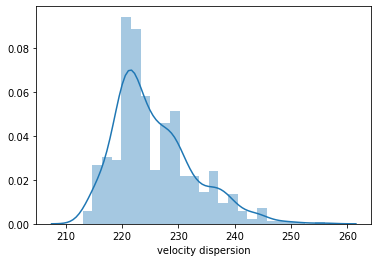

In [30]:
p = pd.read_csv('vel_dis_MC_new.txt', delimiter=' ', header=None) #names=['velocity_dispersion', 'chi^2'])
vel = p[2]
print('std = %f' %np.std(vel))
print('mean = %f' %np.mean(vel))
sn.distplot(vel)
plt.xlabel('velocity dispersion')


Reading spectrum from ../TEXT/147700.txt
Expected file format: text
 Spectrum Start:  3465.00
 Spectrum End:     9469.00
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



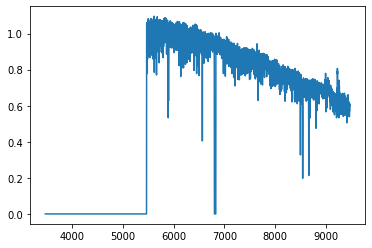

In [183]:
t = spec1d.Spec1d('../TEXT/147700.txt')
plt.plot(lamda_template, t['flux'])

### Next we need to check whether these template files we have extracted given the weight array are trully the used templates in the fit. To do that here I am providing only those template files to the ppxf and check whether the results match. For example previously we provided 200 templates to the ppxf to fit. However now we are just providing only those 14 templates which we believe been used during the fit and match the results from both case. We found that the results match for all the different template number scenario from 200 to 800.

In [ ]:
for i, p in enumerate(total_used_template_list):
    
    used_templates_binned = np.empty((spectra_template_rebinned.size, len(p)))
    
    print('Provided template number : %d' %len(p))
    print('we are predicting used template number would be : %d \n' %len(p))
    
    for l, f in enumerate(p):
        
        #filename.append(file_name)
        
        template_data = spec1d.Spec1d(f, verbose=False)
        template_spectra = template_data['flux']

        # perform convolution with variable sigma_diff    
        convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

        template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
        used_templates_binned[:, l] = template_spectra_rebinned / np.median(template_spectra_rebinned)
    
    pp = ppxf(used_templates_binned, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
                 plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy))
    

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112201       235    -0.031     0.008
chi2/DOF: 1.177
method = capfit; Jac calls: 3; Func calls: 17; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 1270


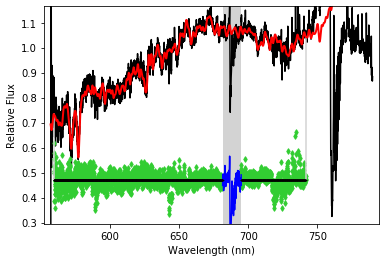

In [205]:
templates,file_name = gen_rebinned_templates(1270, sample(total_template_set, 20), sigma_diff)
pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))
    

In [200]:
temp_index = []
for j, weight in enumerate(pp.weights):
    
    if weight > 10.0:
        temp_index.append(j)
    
#used_template = []
for k, index in enumerate(temp_index):
    
    print(file_name[index])

../TEXT/156164.txt
../TEXT/13475.txt


In [28]:
cnt_1 = Counter()
for i, p in enumerate(fl):
    
    for j, m in enumerate(p):
        
        cnt_1[m] += 1

49